In [1]:
# final_pipeline.ipynb
# Basic imports + plotting style

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from hmm_utils import (
    baum_welch_train,
    viterbi_decode,
    count_num_params,
    compute_aic_bic,
)

# make plots a bit bigger, nothing fancy
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

DATA_PATH = Path("data") / "raw" / "hpi_po_summary.xlsx"


In [2]:
# Load FHFA HPI and build a clean time series with log returns.

def load_and_preprocess_hpi(filepath):
    """
    Load FHFA HPI data and build a univariate time series.

    This function will depend on the exact CSV format.
    For now the idea is:
      - filter national, seasonally-adjusted, purchase-only HPI
      - keep date and index level columns
      - compute log-returns as observations
    """
    df_raw = pd.read_excel(filepath)

    # TODO: adapt these column names / filters to the actual FHFA schema.
    # Example placeholder:
    # df = df_raw[df_raw["Level"] == "National"]
    # df = df[df["Seasonally_Adjusted"] == "Yes"]
    # df = df[df["Index_Type"] == "Purchase-Only"]
    
    # Clean up dataframe
    # Row 0 contains headers, so set it as the header
    df_raw.columns = df_raw.iloc[0]
    # Drop the first row as it is now the header
    df_raw = df_raw.iloc[1:]

    # First strip newline characters from column names, replace with spaces. 
    # (remove newlines, extra spaces)
    df_raw.columns = (
        df_raw.columns
        .str.replace("\n", " ", regex=False)
        .str.strip()
    )

    
    # Rename long columns names to shorter names
    df_raw = df_raw.rename(columns={
        'Not Seasonally-Adjusted Purchase-Only Index  (1991Q1=100)': 'Index',
        'Seasonally-Adjusted Purchase-Only Index  (1991Q1=100)': 'Adjusted Index',
        'Not Seasonally-Adjusted Purchase-Only Index % Change Over  Previous Quarter': 'Index Change Over Previous Quarter',
        'Seasonally-Adjusted Purchase-Only Index % Change Over  Previous Quarter': 'Adjusted Index Change Over Previous Quarter',
        'Not Seasonally-Adjusted Purchase-Only Index % Change Over  Previous 4 Quarters': 'Index Change Over Previous Year',
        'Seasonally-Adjusted Purchase-Only Index % Change Over  Previous 4 Quarters': 'Adjusted Index Change Over Previous Year'
    })
    # Drop unecessary columns
        # (ASSUMING we only want seasonally-adjusted data for now)
        # Dropped 'Region' column because this is national data only, so Region is always USA
        # Dropped 'Index' column because we are using seasonally-adjusted index
        # Dropped change columns because we will compute returns ourselves
    df_raw = df_raw.drop(columns=[
        'Region',
        'Index',
        'Index Change Over Previous Quarter',
        'Adjusted Index Change Over Previous Quarter',
        'Index Change Over Previous Year',
        'Adjusted Index Change Over Previous Year'
    ])


    # Renamed columns for consistency
    df_raw = df_raw.rename(columns={
        'Adjusted Index': 'hpi',
        'Year' : 'year',
        'Quarter' : 'quarter'
    })


    # Drop rows with any missing values
    df_raw = df_raw.dropna()
    # Reset index
    df_raw = df_raw.reset_index(drop=True)
    # Convert all columns to numeric type
    for col in df_raw.columns:
        df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')


    # For now, assume the file is already just one series:
    df = df_raw.copy()

    # parse date if needed
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df = df.sort_values("date")
    else:
        # if no date column, just make an integer index as time
        df = df.sort_index()

    # assume the HPI level is in a column called "hpi"
    if "hpi" not in df.columns:
        raise ValueError("Please rename your HPI level column to 'hpi' or update this function.")

    # compute log-returns
    df["log_hpi"] = np.log(df["hpi"])
    df["ret"] = df["log_hpi"].diff()

    # --- FIX: explicitly remove the first row (ret should be NaN) ---
    if df["ret"].iloc[0] == 0.0:
        df = df.iloc[1:].reset_index(drop=True)

    # drop first NaN return
    df = df.dropna(subset=["ret"]).reset_index(drop=True)

    return df


df = load_and_preprocess_hpi(DATA_PATH)

# Create a proper timestamp for quarterly data
df["date"] = pd.PeriodIndex(year=df["year"], quarter=df["quarter"], freq="Q").to_timestamp()
df = df.sort_values("date").reset_index(drop=True)

df.head()


/var/folders/bv/yk_75xbx1mx91_j824zf9h7w0000gn/T/ipykernel_86261/324288353.py:109: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  df["date"] = pd.PeriodIndex(year=df["year"], quarter=df["quarter"], freq="Q").to_timestamp()


,year,quarter,hpi,log_hpi,ret,date
0,1991,2,100.00,4.605170,0.000000,1991-04-01
1,1991,3,100.17,4.606869,0.001699,1991-07-01
2,1991,4,101.05,4.615615,0.008747,1991-10-01
3,1992,1,102.27,4.627616,0.012001,1992-01-01
4,1992,2,102.12,4.626149,-0.001468,1992-04-01


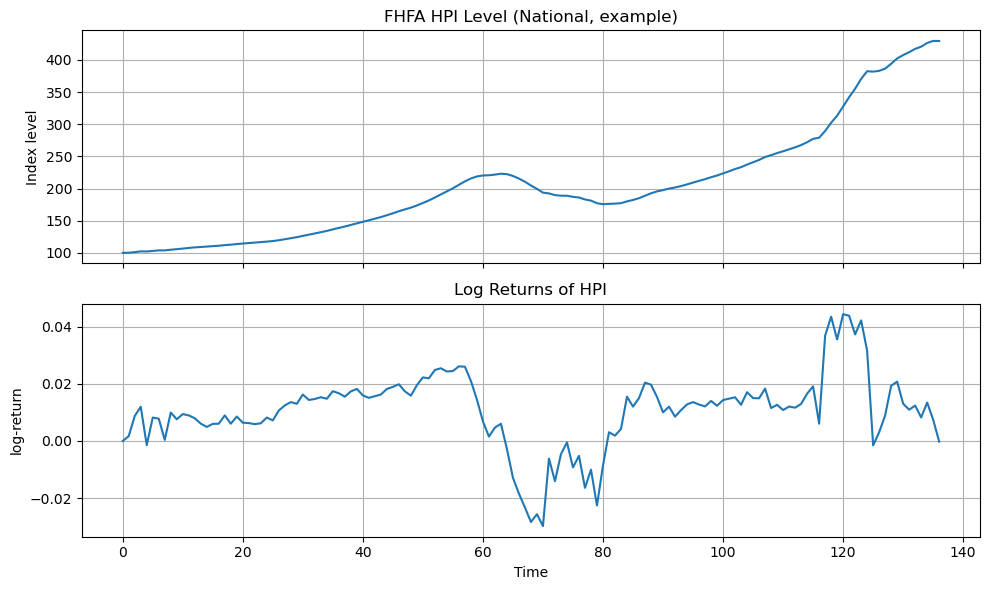

In [3]:
# Quick sanity check plots

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# df already sorted by date in load function
axes[0].plot(df.index, df["hpi"]) # 1991Q2 ~ 2025Qx
axes[0].set_title("FHFA HPI Level (National, example)")
axes[0].set_ylabel("Index level")

axes[1].plot(df.index, df["ret"])
axes[1].set_title("Log Returns of HPI")
axes[1].set_ylabel("log-return")
axes[1].set_xlabel("Time")

plt.tight_layout()
plt.show()

In [4]:
# Helper to train an HMM for a given K and collect metrics.

def train_and_evaluate_hmm_for_k(observations, K, max_iters=100, n_restarts=3, seed=0):
    """
    Train a Gaussian HMM with K states on the given 1D observations.

    This wraps:
      - Baum-Welch training (from mini-project style code)
      - Viterbi decoding
      - AIC/BIC calculation

    Returns a simple dict storing everything we care about.
    """
    T = len(observations)

    best_params, loglik_trace = baum_welch_train(
        observations,
        K,
        max_iters=max_iters,
        tol=1e-6,
        n_restarts=n_restarts,
        seed=seed,
    )

    final_loglik = loglik_trace[-1]
    num_params = count_num_params(K)
    aic, bic = compute_aic_bic(final_loglik, num_params, T)

    viterbi_path = viterbi_decode(observations, best_params)

    result = {
        "K": K,
        "params": best_params,
        "loglik_trace": loglik_trace,
        "final_loglik": final_loglik,
        "AIC": aic,
        "BIC": bic,
        "viterbi_path": viterbi_path,
    }
    return result

In [5]:
# Train HMMs with K = 2, 3, 4 and store results.

observations = df["ret"].values

results_by_k = {}

for K in [2, 3, 4]:
    print(f"Training HMM with K = {K}...")
    res = train_and_evaluate_hmm_for_k(observations, K, max_iters=100, n_restarts=3, seed=42)
    results_by_k[K] = res
    print(f"  final log-likelihood: {res['final_loglik']:.2f}, BIC: {res['BIC']:.2f}")

Training HMM with K = 2...
  final log-likelihood: 455.49, BIC: -876.53
Training HMM with K = 3...
  final log-likelihood: 482.71, BIC: -896.55
Training HMM with K = 4...
  final log-likelihood: 521.48, BIC: -929.80


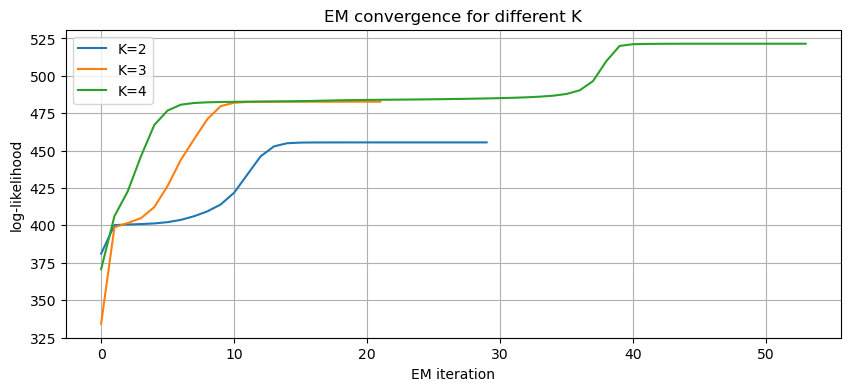

In [6]:
# Plot log-likelihood vs iteration to see if EM is behaving.

plt.figure()
for K, res in results_by_k.items():
    trace = res["loglik_trace"]
    plt.plot(trace, label=f"K={K}")
plt.xlabel("EM iteration") # EM iteration count
plt.ylabel("log-likelihood")
plt.title("EM convergence for different K")
plt.legend()
plt.show()

In [7]:
# Quick comparison of K in tabular form.

rows = []
for K, res in results_by_k.items():
    rows.append(
        {
            "K": K,
            "final_loglik": res["final_loglik"],
            "AIC": res["AIC"],
            "BIC": res["BIC"],
        }
    )

df_k_compare = pd.DataFrame(rows).sort_values("K")
df_k_compare

,K,final_loglik,AIC,BIC
0,2,455.487076,-896.974152,-876.534286
1,3,482.712945,-937.425890,-896.546157
2,4,521.479544,-996.959088,-929.799527


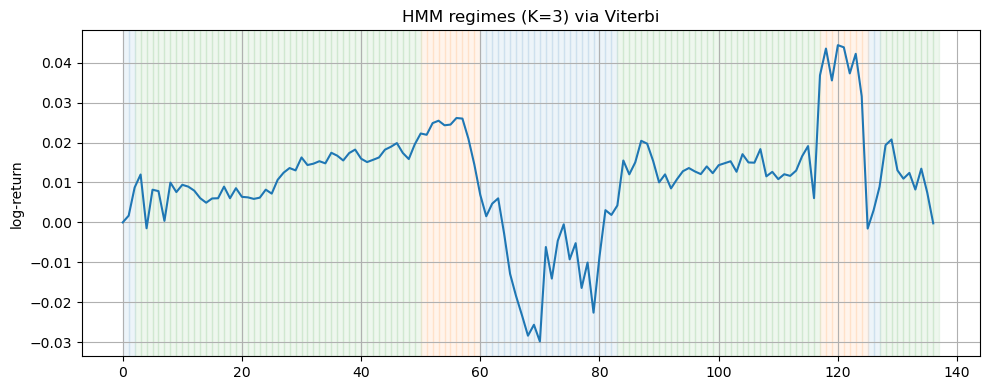

In [8]:
# Plot the Viterbi path for K=3 as colored bands under the returns.

K_target = 3
res_k3 = results_by_k[K_target]
path = res_k3["viterbi_path"]

# For a chill visualization, we just map states to colors.
state_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(df.index, df["ret"], label="log-return")
ax1.set_ylabel("log-return")
ax1.set_title(f"HMM regimes (K={K_target}) via Viterbi")

# add regime bands as a background color bar
# we draw vertical segments; simple but works
for t in range(len(df)):
    ax1.axvspan(
        t,
        t+1,
        color=state_colors[path[t]],
        alpha=0.08,
    )

plt.tight_layout()
plt.show()

In [11]:
# save the key plots and print a short summary for the report.
# save the clean data for 02_analysis.

FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

# save the K comparison table as CSV
df_k_compare.to_csv(FIG_DIR / "k_compare.csv", index=False)

print("K comparison summary:")
print(df_k_compare.to_string(index=False))


# Save clean quarterly HPI after preprocessing
CLEAN_PATH = Path("data") / "hpi_quarterly_clean.csv"
df.to_csv(CLEAN_PATH, index=False)
print("\nSaved clean dataset to:", CLEAN_PATH)


print("\n01_final_pipeline all Done.")
print("Please go to 02_analysis.")

K comparison summary:
 K  final_loglik         AIC         BIC
 2    455.487076 -896.974152 -876.534286
 3    482.712945 -937.425890 -896.546157
 4    521.479544 -996.959088 -929.799527

Saved clean dataset to: data/hpi_quarterly_clean.csv

01_final_pipeline all Done.
Please go to 02_analysis.
